In [46]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
from zipfile import ZipFile
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.applications import ResNet50

In [4]:
print(os.listdir("data"))
dataset = []
labels = []

['sample_submission.csv', 'test.csv', 'test_images', 'train.csv', 'train_images']


In [5]:
def prepare_Images(label,path):
    img=cv2.imread(path,cv2.IMREAD_COLOR)
    img_res=cv2.resize(img,(50,50))
    img_array = img_to_array(img_res)
    img_array = img_array/255
    dataset.append(img_array)
    labels.append(str(label))

In [6]:
train_Data = pd.read_csv("data/train.csv")
train_Data.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [7]:
id_code_Data = train_Data['id_code']
diagnosis_Data = train_Data['diagnosis']

In [8]:
for id_code,diagnosis in tqdm(zip(id_code_Data,diagnosis_Data)):
    path = os.path.join('data/train_images','{}.png'.format(id_code))
    prepare_Images(diagnosis,path)

3662it [03:39, 16.72it/s]


In [9]:
#Convert list to numpy array
images = np.array(dataset)
label_arr = np.array(labels)

In [10]:
#spliting the training data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(images,label_arr,test_size=0.20,random_state=42)

In [11]:
#Convert to class labels categorical
y_train = np_utils.to_categorical(y_train, num_classes=5)
y_test = np_utils.to_categorical(y_test, num_classes=5)

In [71]:
# Building model
model=Sequential()
model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(5,activation="softmax"))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 50, 50, 16)        208       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 25, 25, 32)        2080      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 12, 12, 64)        8256      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 6, 6, 128)       

In [72]:
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                    patience=3, 
                                    verbose=1, 
                                    factor=0.2, 
                                    min_lr=0.0001)

In [73]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train,y_train,batch_size=64,epochs=10,verbose=1,callbacks=[learning_rate_reduction],validation_data=(x_test, y_test))

Train on 2929 samples, validate on 733 samples
Epoch 1/10
2929/2929 [==============================] - 1s 267us/step - loss: 1.1541 - accuracy: 0.5507 - val_loss: 0.8988 - val_accuracy: 0.7040
Epoch 2/10
2929/2929 [==============================] - 1s 182us/step - loss: 0.8578 - accuracy: 0.6920 - val_loss: 0.8123 - val_accuracy: 0.7121
Epoch 3/10
2929/2929 [==============================] - 1s 180us/step - loss: 0.7965 - accuracy: 0.7040 - val_loss: 0.7856 - val_accuracy: 0.7258
Epoch 4/10
2929/2929 [==============================] - 1s 181us/step - loss: 0.7617 - accuracy: 0.7187 - val_loss: 0.7556 - val_accuracy: 0.7312
Epoch 5/10
2929/2929 [==============================] - 1s 181us/step - loss: 0.7383 - accuracy: 0.7296 - val_loss: 0.7353 - val_accuracy: 0.7340
Epoch 6/10
2929/2929 [==============================] - 1s 183us/step - loss: 0.7264 - accuracy: 0.7320 - val_loss: 0.7492 - val_accuracy: 0.7326
Epoch 7/10
2929/2929 [==============================] - 1s 179us/step - loss:

In [86]:
from keras.applications import DenseNet121
from keras.layers import GlobalAveragePooling2D

densenet = DenseNet121(include_top=False,
                 weights=None,
                 input_shape=(50,50,3))

model = Sequential()
model.add(densenet)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(5, activation='sigmoid'))
    
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(lr=0.00005),
    metrics=['accuracy']
)
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1, 1, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________
None


In [92]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

opt = keras.optimizers.SGD(lr=0.005, decay=1e-6, momentum=0.9, nesterov=True)
Callbacks=[EarlyStopping(patience=16, restore_best_weights=True), 
           ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, verbose=True)]

In [107]:
history = model.fit(x_train,y_train,batch_size=64,epochs=40,verbose=1,callbacks=Callbacks,validation_data=(x_test, y_test))

Train on 2929 samples, validate on 733 samples
Epoch 1/40
2929/2929 [==============================] - 11s 4ms/step - loss: 0.0876 - accuracy: 0.9731 - val_loss: 0.3341 - val_accuracy: 0.8789
Epoch 2/40
2929/2929 [==============================] - 11s 4ms/step - loss: 0.0747 - accuracy: 0.9774 - val_loss: 0.3390 - val_accuracy: 0.8838
Epoch 3/40
2929/2929 [==============================] - 11s 4ms/step - loss: 0.0715 - accuracy: 0.9779 - val_loss: 0.3269 - val_accuracy: 0.8879
Epoch 4/40
2929/2929 [==============================] - 11s 4ms/step - loss: 0.0637 - accuracy: 0.9825 - val_loss: 0.3338 - val_accuracy: 0.8950
Epoch 5/40
2929/2929 [==============================] - 11s 4ms/step - loss: 0.0573 - accuracy: 0.9825 - val_loss: 0.3418 - val_accuracy: 0.8884
Epoch 6/40
2929/2929 [==============================] - 11s 4ms/step - loss: 0.0570 - accuracy: 0.9829 - val_loss: 0.3724 - val_accuracy: 0.8805
Epoch 7/40
2929/2929 [==============================] - 11s 4ms/step - loss: 0.0498

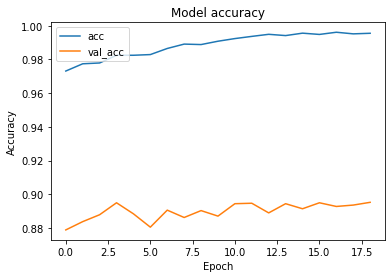

In [108]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()

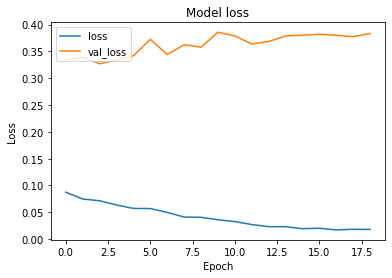

In [109]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [110]:
pred = model.predict(x_test)

In [111]:
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
score = round(accuracy_score(y_test.argmax(axis=1), pred.argmax(axis=1)),2)
print(score)

0.71


In [112]:
report = classification_report(y_test.argmax(axis=1), pred.argmax(axis=1))
print(report)

precision    recall  f1-score   support

           0       0.88      0.98      0.93       351
           1       0.45      0.32      0.38        68
           2       0.64      0.60      0.62       213
           3       0.20      0.11      0.14        36
           4       0.27      0.31      0.29        65

    accuracy                           0.71       733
   macro avg       0.49      0.46      0.47       733
weighted avg       0.68      0.71      0.69       733



In [113]:
conMat = confusion_matrix(y_test.argmax(axis=1),pred.argmax(axis=1))
print(conMat)

[[344   1   5   0   1]
 [  9  22  22   1  14]
 [ 21  20 128  10  34]
 [  5   3  19   4   5]
 [ 11   3  26   5  20]]


In [114]:
test_df = pd.read_csv('data/test.csv')
test_df.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


In [115]:
x = test_df['id_code']
test_Dataset = []

In [116]:
def make_test_data(path):
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    img_res = cv2.resize(img, (50,50))
    img_array = img_to_array(img_res)
    img_array = img_array/255
    test_Dataset.append(img_array)

In [117]:
for id_code in tqdm(x):
    path = os.path.join('data/test_images','{}.png'.format(id_code))
    make_test_data(path)
test_image = np.array(test_Dataset)
pred=model.predict(test_image)
pred=np.argmax(pred,axis=1)
pred

40%|███▉      | 764/1928 [00:15<00:24, 48.16it/s]


KeyboardInterrupt: 

In [45]:
sub_df = pd.read_csv('data/sample_submission.csv')
sub_df.diagnosis = pred
sub_df.to_csv("submission.csv",index=False)